In [105]:
import tensorflow as tf
from tensorflow.contrib.framework.python.framework import checkpoint_utils

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

In [3]:
MODEL_DIR_OCCUPATION = 'gs://conversationai-models/tf_trainer_runs/fprost/tf_gru_attention_multiclass_biosbias_glove/20190328_103117/model_dir/model.ckpt-100000'
MODEL_DIR_GENDER = [
    'gs://conversationai-models/tf_trainer_runs/fprost/tf_gru_attention_multiclass_warmstart_biosbias_glove/20190411_145753/model_dir/model.ckpt-215000',
    'gs://conversationai-models/tf_trainer_runs/fprost/tf_gru_attention_multiclass_warmstart_biosbias_glove/20190411_152404/model_dir/model.ckpt-249000',
    'gs://conversationai-models/tf_trainer_runs/fprost/tf_gru_attention_multiclass_warmstart_biosbias_glove/20190411_152451/model_dir/model.ckpt-186000',
    'gs://conversationai-models/tf_trainer_runs/fprost/tf_gru_attention_multiclass_warmstart_biosbias_glove/20190411_152506/model_dir/model.ckpt-163000',
]

# Extract two matrices.

In [4]:
var_list = checkpoint_utils.list_variables(MODEL_DIR_OCCUPATION)
for v in var_list:
    print(v)

('dense/bias', [1])
('dense/bias/Adam', [1])
('dense/bias/Adam_1', [1])
('dense/kernel', [256, 1])
('dense/kernel/Adam', [256, 1])
('dense/kernel/Adam_1', [256, 1])
('dense_1/bias', [128])
('dense_1/bias/Adam', [128])
('dense_1/bias/Adam_1', [128])
('dense_1/kernel', [256, 128])
('dense_1/kernel/Adam', [256, 128])
('dense_1/kernel/Adam_1', [256, 128])
('dense_2/bias', [33])
('dense_2/bias/Adam', [33])
('dense_2/bias/Adam_1', [33])
('dense_2/kernel', [128, 33])
('dense_2/kernel/Adam', [128, 33])
('dense_2/kernel/Adam_1', [128, 33])
('embeddings', [400002, 100])
('global_step', [])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/bias', [256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/bias/Adam', [256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/bias/Adam_1', [256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel', [356, 256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel/Adam', [356, 256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel/Adam_1', [356, 256])
('

In [5]:
kernel_occupation = np.transpose(checkpoint_utils.load_variable(MODEL_DIR_OCCUPATION, 'dense_2/kernel'))

In [7]:
var_list = checkpoint_utils.list_variables(MODEL_DIR_GENDER[0])
for v in var_list:
    print(v)

('beta1_power', [])
('beta2_power', [])
('dense/bias', [1])
('dense/kernel', [256, 1])
('dense_1/bias', [128])
('dense_1/kernel', [256, 128])
('embeddings', [400002, 100])
('final_layer/bias', [1])
('final_layer/bias/Adam', [1])
('final_layer/bias/Adam_1', [1])
('final_layer/kernel', [128, 1])
('final_layer/kernel/Adam', [128, 1])
('final_layer/kernel/Adam_1', [128, 1])
('global_step', [])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/bias', [256])
('rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel', [356, 256])
('rnn/multi_rnn_cell/cell_0/gru_cell/gates/bias', [512])
('rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel', [356, 512])
('signal_early_stopping/STOP', [])


In [18]:
kernel_gender = [np.transpose(checkpoint_utils.load_variable(d, 'final_layer/kernel')) for d in MODEL_DIR_GENDER]

# Compute cosine.

In [20]:
TITLE_LABELS = [
    'accountant', 'acupuncturist', 'architect', 'attorney', 'chiropractor', 'comedian', 'composer', 'dentist',
    'dietitian', 'dj', 'filmmaker', 'interior_designer', 'journalist', 'landscape_architect', 'magician',
    'massage_therapist', 'model', 'nurse', 'painter', 'paralegal', 'pastor', 'personal_trainer',
    'photographer', 'physician', 'poet', 'professor', 'psychologist', 'rapper',
    'real_estate_broker', 'software_engineer', 'surgeon', 'teacher', 'yoga_teacher']

In [19]:
kernel_gender[0].shape

(1, 128)

In [57]:
# compare every pair of kernel genders
def compare_gender_dirs(i, j):
    k1 = normalize(kernel_gender[i].reshape(1, -1))
    k2 = normalize(kernel_gender[j].reshape(1, -1))
    return cosine_similarity(k1, k2)[0][0]

In [59]:
print('cosine similarity')
print('-----------------')
for i in range(len(kernel_gender)):
    for j in range(i+1, len(kernel_gender)):
        print('{}&{}: {:.4f}'.format(i,j,compare_gender_dirs(i,j)))

cosine similarity
-----------------
0&1: 0.6751
0&2: 0.6922
0&3: 0.5317
1&2: 0.8031
1&3: 0.6210
2&3: 0.7388


In [16]:
# Compute mean
kernel_occupation_mean = np.mean(kernel_occupation, axis=0)
# Apply  x - np.sum(np.multiply(x, mean))* mean

In [103]:
biases = []
for i in range(len(kernel_gender)):
    biases.append([])
    print('Model {}'.format(i))
    print('--------')
    for j in range(33):
        _bias = float(cosine_similarity(kernel_gender[i], kernel_occupation[j].reshape(1, -1)))
        biases[i].append(_bias)
        print ('{}:{}'.format(TITLE_LABELS[j], _bias))
    print('')

Model 0
--------
accountant:0.158934131265
acupuncturist:-0.00246658176184
architect:0.0262414831668
attorney:0.0701843947172
chiropractor:0.151446655393
comedian:0.160642623901
composer:0.123556695879
dentist:-0.0134080462158
dietitian:-0.0219126939774
dj:0.148254662752
filmmaker:0.126566886902
interior_designer:-0.122405454516
journalist:0.0449348725379
landscape_architect:-0.0106348320842
magician:0.00028520077467
massage_therapist:-0.0029302239418
model:-0.110116116703
nurse:-0.122437313199
painter:-0.0652433410287
paralegal:-0.0483433827758
pastor:0.190286368132
personal_trainer:0.09811873734
photographer:0.156098395586
physician:-0.00970926880836
poet:0.0886058360338
professor:0.0128441434354
psychologist:-0.022803556174
rapper:0.123992994428
real_estate_broker:-0.0125496685505
software_engineer:0.043130338192
surgeon:0.132479757071
teacher:0.0157231092453
yoga_teacher:-0.0365795046091

Model 1
--------
accountant:0.154791727662
acupuncturist:-0.0237082242966
architect:0.08414058

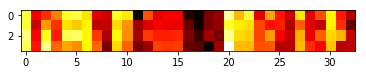

In [108]:
# Heatmap of cosine similarities
plt.imshow(np.array(biases), cmap='hot', interpolation='nearest')
plt.show()